In [2]:
# Imports
import re
import pathlib
import itertools
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Define some useful function

def MiB_to_Gb(val):
    return val*8*1024**2/10**9

def Gb_to_MiB(val):
    return val*10**9/(8*1024**2)

def parse_datetime(s: str):
    """Carefully parses the specific datetime string used by warp"""
    other, decimal = s.split('.')
    decimal_rounded = f"{float('0.'+decimal.rstrip('Z')):.6f}"[1:]
    return dt.datetime.strptime(other + decimal_rounded, '%Y-%m-%dT%H:%M:%S.%f')

def load_raw_data(results_file, check_error=True):
    """Load and preprocess raw benchmark data from `warp`"""
    df = pd.read_csv(results_file, sep="\t")
    # Separate out benchmark command
    warp_command = df.iloc[-1].idx
    df = df.iloc[:-1]
    # Drop some unused columns
    df = df.drop(['idx'], axis=1)
    if check_error:
        if df.error.isna().all():
            df = df.drop('error', axis=1)
        else:
            raise Exception("Errors found in df.error column")
    if df.n_objects.eq(1).all():
        df = df.drop('n_objects', axis=1)
    # Convert some data dtypes
    for col in ['start', 'end']:
        df[col] = df[col].map(parse_datetime)    
    return df, warp_command

def load_summary_data(filename):
    """Loads the summary csv data from `warp analyze ...` into a pandas dataframe"""
    df = pd.read_csv(filename, sep="\t")
    df = df[~(df.op == "op")]
    for col in ['mb_per_sec', 'objs_per_sec']:
        df[col] = pd.to_numeric(df[col])
    return df

def parse_text_summary(filename):
    """Parses the text summary from `warp analyze ...` and generates a dict of throughput values"""
    # Read input and compile reusable regexs
    op_regex = re.compile(r"[A-Z][A-Z]+")
    score_regex = re.compile(r"[0-9]+\.[0-9]+\ [a-zA-Z]+/s")
    with open(filename, "r") as file:
        lines = file.readlines()
    # Iterate through file lines and extract relevant pieces
    scores = {}
    current_op = None
    for line in lines:
        if line.startswith("Operation: "):
            op = op_regex.search(line)[0]
            current_op = op
            scores[op] = {}
        elif line.startswith(" * Throughput: ") or line.startswith("* Average:"):
            for score in score_regex.finditer(line):
                val, unit = score[0].split(" ")
                scores[current_op][unit] = float(val)
        elif line.startswith("Cluster Total: "):
            scores["Total"] = {}
            for score in score_regex.finditer(line):
                val, unit = score[0].split(" ")
                scores["Total"][unit] = float(val)
    # Convert obj/s to kIOPS
    for op in scores.keys():
        if 'obj/s' in scores[op].keys():
            val = scores[op].pop('obj/s')
            scores[op]['kIOPS'] = val / 1000
        
    return scores

parse_text_summary("benchmark-runs/s3-summary.pure-get-1-1-250-100MiB.txt")

{'PUT': {'MiB/s': 250.55, 'kIOPS': 0.0025099999999999996},
 'GET': {'MiB/s': 462.8, 'kIOPS': 0.00463}}

# Outlier investigation

In [94]:
# df, cmd = load_raw_data('benchmark-runs/s3-full.quobyte-get-5-50-1GiB-1000-60s.csv.zst')
df, cmd = load_raw_data('benchmark-runs/s3-full.pure-get-1-1-10KiB-1000-300s.csv.zst')

/tmp/ipykernel_617/1267593836.py:26: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(results_file, sep="\t")


In [96]:
df[df.op == 'PUT']

,thread,op,client_id,bytes,endpoint,file,start,first_byte,end,duration_ns
0,0.0,PUT,8dCoXN,10240.0,http://172.26.70.68,R8gedLk0/1.(qt5ezIZCoM)9Txz.rnd,2023-03-15 10:48:16.533164,NaN,2023-03-15 10:48:16.535080,1915968.0
1,0.0,PUT,8dCoXN,10240.0,http://172.26.70.68,R8gedLk0/3.fuN3lcqIlZr2IKtO.rnd,2023-03-15 10:48:16.535093,NaN,2023-03-15 10:48:16.536869,1775986.0
2,0.0,PUT,8dCoXN,10240.0,http://172.26.70.68,R8gedLk0/5.Ly5ynEZBZJ0tHpgv.rnd,2023-03-15 10:48:16.536873,NaN,2023-03-15 10:48:16.538317,1444262.0
3,0.0,PUT,8dCoXN,10240.0,http://172.26.70.68,R8gedLk0/7.HAFkX0caH9qBCkge.rnd,2023-03-15 10:48:16.538325,NaN,2023-03-15 10:48:16.539871,1545943.0
4,0.0,PUT,8dCoXN,10240.0,http://172.26.70.68,R8gedLk0/9.PdesbVYJgzXwt9He.rnd,2023-03-15 10:48:16.539874,NaN,2023-03-15 10:48:16.541539,1664204.0
...,...,...,...,...,...,...,...,...,...,...
995,0.0,PUT,8dCoXN,10240.0,http://172.26.70.68,R8gedLk0/1991.2tQD72mVlUsnIEVg.rnd,2023-03-15 10:48:17.805126,NaN,2023-03-15 10:48:17.806237,1111017.0
996,0.0,PUT,8dCoXN,10240.0,http://172.26.70.68,R8gedLk0/1993.XdumBAlmz4buip0E.rnd,2023-03-15 10:48:17.806240,NaN,2023-03-15 10:48:17.807315,1075145.0
997,0.0,PUT,8dCoXN,10240.0,http://172.26.70.68,R8gedLk0/1995.kL8SoEi1WJ8I)fJg.rnd,2023-03-15 10:48:17.807317,NaN,2023-03-15 10:48:17.808411,1094187.0
998,0.0,PUT,8dCoXN,10240.0,http://172.26.70.68,R8gedLk0/1997.zHz9YNHxFe06LTk(.rnd,2023-03-15 10:48:17.808414,NaN,2023-03-15 10:48:17.809628,1214547.0


In [97]:
stats_per_thread = df[df.op == 'PUT'].groupby('thread').duration_ns.describe()
cols = [col for col in stats_per_thread if col != 'count']
stats_per_thread[cols] = stats_per_thread[cols] / 1e9
stats_per_thread.sort_values('max')

,count,mean,std,min,25%,50%,75%,max
thread,,,,,,,,
0.0,1000.0,0.001275,0.000339,0.000988,0.001139,0.001198,0.001285,0.006644


In [99]:
df[df.op == 'PUT'].duration_ns.sum() / 1e9

1.274677659

In [100]:
stats_per_thread = df[df.op == 'PUT'].groupby('client_id').duration_ns.describe()
cols = [col for col in stats_per_thread if col != 'count']
stats_per_thread[cols] = stats_per_thread[cols] / 1e9
stats_per_thread

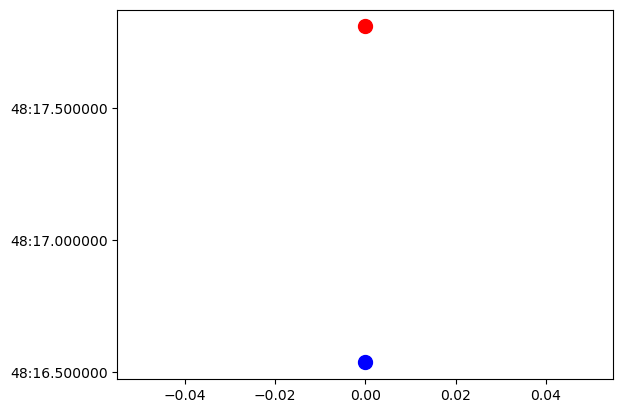

In [101]:
fig, ax = plt.subplots()
col = 'thread'
op = 'PUT'

first_request_completed = df[df.op == op].groupby(col).end.first()
ax.scatter(first_request_completed.index, first_request_completed.values, s=3, c='b')
idx = first_request_completed.idxmax()
ax.scatter([idx], [first_request_completed[idx]], s=100, c='b')

last_request_completed = df[df.op == op].groupby(col).end.last()
ax.scatter(last_request_completed.index, last_request_completed.values, s=3, c='r')
idx = last_request_completed.idxmin()
ax.scatter([idx], [last_request_completed[idx]], s=100, c='r')
plt.show()

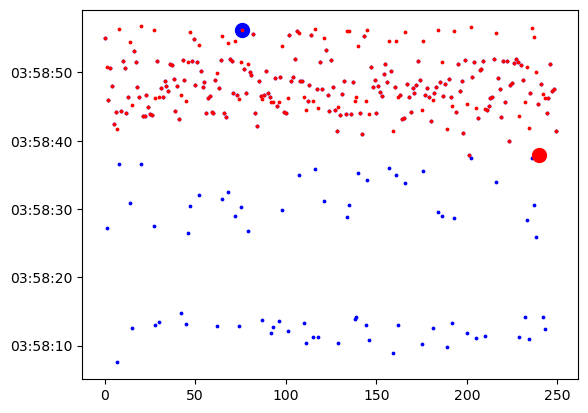

In [92]:
fig, ax = plt.subplots()
col = 'thread'
op = 'GET'

first_request_completed = df[df.op == op].groupby(col).end.first()
ax.scatter(first_request_completed.index, first_request_completed.values, s=3, c='b')
idx = first_request_completed.idxmax()
ax.scatter([idx], [first_request_completed[idx]], s=100, c='b')

last_request_completed = df[df.op == op].groupby(col).end.last()
ax.scatter(last_request_completed.index, last_request_completed.values, s=3, c='r')
idx = last_request_completed.idxmin()
ax.scatter([idx], [last_request_completed[idx]], s=100, c='r')
plt.show()

# Throughput calculation attempts

In [29]:
df, cmd = load_raw_data('benchmark-runs/s3-full.quobyte-get-5-1-100MiB-100-300s.csv.zst')
# df, cmd = load_raw_data('benchmark-runs/s3-full.quobyte-get-5-1-10MiB-1000-300s.csv.zst')
df

,thread,op,client_id,bytes,endpoint,file,start,first_byte,end,duration_ns
0,3.0,PUT,nOa30i,104857600.0,http://s3.sds.jc.rl.ac.uk,Szg7njpo/1.KgPWKWcBo76(9dTC.rnd,2023-03-14 19:08:26.431179,NaN,2023-03-14 19:08:38.248709,1.181753e+10
1,2.0,PUT,5alvDu,104857600.0,http://s3.sds.jc.rl.ac.uk,JtrOLXW1/1.O5esz7xVQt1SoDvP.rnd,2023-03-14 19:08:26.431216,NaN,2023-03-14 19:08:30.689623,4.258407e+09
2,4.0,PUT,ddhaNa,104857600.0,http://s3.sds.jc.rl.ac.uk,lWep8J9r/1.bbG7LnY(aHPDuiXN.rnd,2023-03-14 19:08:26.431647,NaN,2023-03-14 19:08:28.986103,2.554456e+09
3,0.0,PUT,YpxlAO,104857600.0,http://s3.sds.jc.rl.ac.uk,nh6il5cL/1.g2cCKLuGvZkXWmKn.rnd,2023-03-14 19:08:26.434116,NaN,2023-03-14 19:08:35.807091,9.372976e+09
4,1.0,PUT,3C3OVe,104857600.0,http://s3.sds.jc.rl.ac.uk,pQ9Xs0BB/1.elm45NqYOHA8HU5G.rnd,2023-03-14 19:08:26.452995,NaN,2023-03-14 19:08:29.111125,2.658129e+09
...,...,...,...,...,...,...,...,...,...,...
5829,1.0,GET,3C3OVe,104857600.0,http://s3.sds.jc.rl.ac.uk,pQ9Xs0BB/39.IFP((0pIwE)xiwZn.rnd,2023-03-14 19:14:27.168312,2023-03-14T19:14:27.229577004Z,2023-03-14 19:14:27.474349,3.060375e+08
5830,0.0,GET,YpxlAO,104857600.0,http://s3.sds.jc.rl.ac.uk,nh6il5cL/35.HndT(S9fKhVEXIsN.rnd,2023-03-14 19:14:27.178076,2023-03-14T19:14:27.22997623Z,2023-03-14 19:14:27.476197,2.981216e+08
5831,2.0,GET,5alvDu,104857600.0,http://s3.sds.jc.rl.ac.uk,JtrOLXW1/27.Pkug)hjME)J(znjE.rnd,2023-03-14 19:14:27.211603,2023-03-14T19:14:27.225353949Z,2023-03-14 19:14:27.588709,3.771057e+08
5832,4.0,GET,ddhaNa,104857600.0,http://s3.sds.jc.rl.ac.uk,lWep8J9r/39.EWX3mOJJzf6ETqT4.rnd,2023-03-14 19:14:27.292628,2023-03-14T19:14:27.306607311Z,2023-03-14 19:14:27.549696,2.570679e+08


In [37]:
def throughput(df, op, bin_size=1):
    print(op)
    df = df[df.op == op]
    # Filter to relevant time window
    groups = df.groupby('thread')
    start_time = groups.end.first().max()
    end_time = groups.start.last().min()
    print(start_time, end_time)
    df = df[(df.start > start_time) & (df.end < end_time)]
    print('Requests considered:', len(df))
    # Add time bin column
    # time_bins = np.arange(start_time.timestamp(), end_time.timestamp(), bin_size)
    time_bins = np.arange(int(start_time.timestamp()), int(end_time.timestamp()), bin_size)
    bin_values = np.digitize(df.start.map(lambda dt: dt.timestamp()), time_bins)
    print('Number of bins:', len(set(bin_values)))
    df = df.join(pd.DataFrame({'time_bin': bin_values}))
    # Calculate throughput per thread & per time bin
    print('Min/max request duration:', df.duration_ns.apply([min, max]).values / 1e9, 's')
    groups = df.groupby(['time_bin'])
    print('Throughput:', groups.bytes.sum().mean() / (bin_size * 1024**2), 'MiB/s')
    # print('Min Throughput:', groups.bytes.sum().min() / (bin_size * 1024**2), 'MiB/s')
    print('Throughput:', (groups.file.count() / bin_size).mean(), 'obj/s')
    print()
    return

throughput(df, 'PUT', bin_size=1)
throughput(df, 'GET', bin_size=1)

PUT
2023-03-14 19:08:38.248709 2023-03-14 19:09:10.162856
Requests considered: 64
Number of bins: 28
Min/max request duration: [1.70394886 4.40380008] s
Throughput: 225.0 MiB/s
Min Throughput: 100.0 MiB/s
Throughput: 2.25 obj/s

GET
2023-03-14 19:09:28.012561 2023-03-14 19:14:27.168312
Requests considered: 5713
Number of bins: 299
Min/max request duration: [0.1578846  4.93112308] s
Throughput: 1905.1020408163265 MiB/s
Min Throughput: 100.0 MiB/s
Throughput: 19.051020408163264 obj/s



In [50]:
def load_scores(base_file_name, **kwargs):

    parameter_combinations = list(itertools.product(*kwargs.values()))
    scores = {}
    for param_set in parameter_combinations:
        file_name = base_file_name
        results_key = ''
        for key, param in zip(kwargs.keys(), param_set):
            results_key += f'{param}-{key}--'
            file_name += f'-{param}'
        file_name += '.txt'
        run_scores = parse_text_summary(file_name)
        scores[results_key] = run_scores
        
    return scores


def plot_grouped_bars(scores, unit, ax=None, op_colours=None):

    groups = list(scores.keys())
    keys = [k for k, v in scores[groups[0]].items() if unit in v.keys()]
    data = {k:[scores[g][k][unit] for g in groups] for k in keys}

    x = np.arange(len(groups))  # the label locations
    width = 1 / (1+len(keys)) # the width of the bars
    multiplier = (1.5 - len(keys)/2)
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 4), constrained_layout=True)
    ax.grid(axis="y", lw=0.5, zorder=0)
    
    for i, (k, score) in enumerate(data.items()):
        offset = width * multiplier
        rects = ax.bar(
            x + offset, 
            score, 
            width, 
            ec="k", 
            label=k, 
            zorder=3,
            color=(op_colours[k] if op_colours is not None else None)
        )
        multiplier += 1

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel(unit.replace("_per_sec", "/s"))
    ax.set_xticks(x + width, groups)    
    
    return ax


def plot_throughput_vs_filesize(scores, op):

    op = op.upper()


OP = 'get'
scores = load_scores(f'benchmark-runs/s3-summary.pure-{OP}', nodes=[1, 2], threads=[1, 20, 50], files=[250], size=['100MiB'])
plot_throughput_vs_filesize(scores, op)

{'1-nodes--1-threads--250-files--100MiB-size--': {'PUT': {'MiB/s': 250.55,
   'kIOPS': 0.0025099999999999996},
  'GET': {'MiB/s': 462.8, 'kIOPS': 0.00463}},
 '1-nodes--20-threads--250-files--100MiB-size--': {'PUT': {'MiB/s': 2934.49,
   'kIOPS': 0.02934},
  'GET': {'MiB/s': 4147.72, 'kIOPS': 0.041479999999999996}},
 '1-nodes--50-threads--250-files--100MiB-size--': {'PUT': {},
  'GET': {'MiB/s': 5221.14, 'kIOPS': 0.05221}},
 '2-nodes--1-threads--250-files--100MiB-size--': {'PUT': {'MiB/s': 494.75,
   'kIOPS': 0.00495},
  'GET': {'MiB/s': 870.79, 'kIOPS': 0.00871}},
 '2-nodes--20-threads--250-files--100MiB-size--': {'PUT': {'MiB/s': 4347.68,
   'kIOPS': 0.04348},
  'GET': {'MiB/s': 7839.52, 'kIOPS': 0.07840000000000001}},
 '2-nodes--50-threads--250-files--100MiB-size--': {'PUT': {'MiB/s': 5332.8,
   'kIOPS': 0.053329999999999995},
  'GET': {'MiB/s': 8165.57, 'kIOPS': 0.08166}}}

In [ ]:
def plot_obj_size_comparison(scores, op, unit, ax):

    
    